<h1 align="center"> Style transfer using Cycle GAN

In [4]:
#Import all the required libraries
import os
import re
import keras
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras import layers, initializers, models
from os import listdir
from numpy import asarray
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils.vis_utils import plot_model
import imageio.v2 as imageio
import tensorflow_docs.vis.embed as embed


#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'2.7.0'

In [3]:
keras.__version__

'2.6.0'

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [4]:
#path to T1 and T2 images
t1 = "mri/Tr1/TrainT1/"
t2 = "mri/Tr2/TrainT2/"

# Image size
img_height = 128
img_width = 128

# list of images
t1_images = [t1 + i for i in os.listdir(t1)]
t2_images = [t2 + i for i in os.listdir(t2)]

# Images count for each category
print("Total Images in each category:\n")
print(f"T1: {len(t1_images)}")
print(f"T2: {len(t2_images)}")

Total Images in each category:

T1: 43
T2: 46


Sample Images from each category:



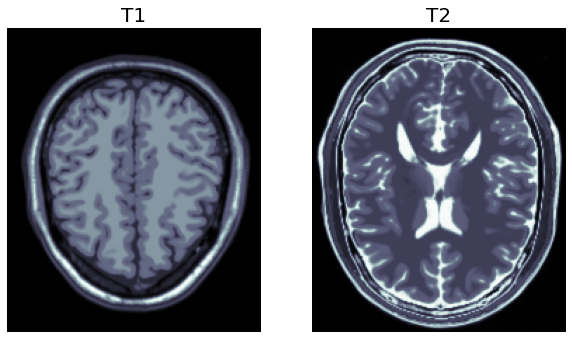

In [5]:
# Priting sample images from each category
print("Sample Images from each category:\n")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(t1_images[0]), cmap="bone")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(t2_images[0]), cmap="bone")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

In [6]:
# function to load and resize images
def load_images(img_list):
    img_arr = []
    for img in img_list:
        img = Image.open(img)
        img_arr.append(np.array(img))
    return np.array(img_arr)

In [7]:
t1_images = load_images(t1_images)
t2_images = load_images(t2_images)
# information of dataset
print(f"t1: {t1_images.shape}")
print(f"t2: {t2_images.shape}")

t1: (43, 217, 181)
t2: (46, 217, 181)


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [8]:
# function to normalize the images to [-1, 1]
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1 
    return image

# function to preprocess images
def preprocess_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [*(img_height, img_width)])
    image = tf.image.random_crop(image, size=[*(img_height, img_width, 1)], seed=42)
    image = normalize(image)   
    return image

In [9]:
# reshaping array to format (height, width, channels) ( Here channels = 1 as it is grayscale)
t1_images = t1_images.reshape(t1_images.shape[0], t1_images.shape[1], t1_images.shape[2], 1).astype("float32")
t2_images = t2_images.reshape(t2_images.shape[0], t2_images.shape[1], t2_images.shape[2], 1).astype("float32")

In [10]:
# Data-augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal")])
t1_images = np.concatenate([data_augmentation(t1_images), t1_images], axis=0)
t2_images = np.concatenate([data_augmentation(t2_images), t2_images], axis=0)

2024-03-20 05:37:35.571000: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-20 05:37:35.571061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [11]:
t1_images = [preprocess_image(image) for image in t1_images]
t2_images = [preprocess_image(image) for image in t2_images]

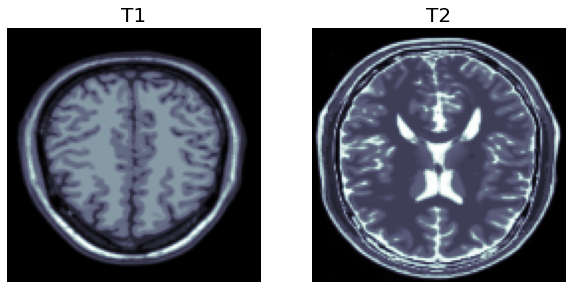

In [12]:
# Printing sample images from each category after preprocessing
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(t1_images[0], cmap="bone")
plt.title("T1", fontsize=20)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(t2_images[0], cmap="bone")
plt.title("T2", fontsize=20)
plt.axis("off")
plt.show()

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [13]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [15]:
# Downsampling method
def downsample(filters, size, apply_norm=True):
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(
            filters,
            size,
            strides=1,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

# Upsampling method
def upsample(filters, size, apply_dropout=False):
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(
            filters,
            size,
            strides=1,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# Generator
def unet_generator():
    inputs = layers.Input(shape=[128, 128, 1])
    
    down_stack = [
        downsample(128, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    # create a stack of downsample models
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(128, 4),
    ]  # create a stack of upsample models

    initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)
    last = layers.Conv2DTranspose(
        1,
        4,
        strides=1,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )
    concat = layers.Concatenate()
    inputs = layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

#initialising the generators
generator_g = unet_generator()
generator_f = unet_generator()

In [16]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 12  2048        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 12  262400      ['sequential_1[0][0]']           
                                8)                                                            

In [17]:
generator_f.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 128, 128, 12  2048        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_16 (Sequential)     (None, 128, 128, 12  262400      ['sequential_15[0][0]']          
                                8)                                                          

In [18]:
def discriminator():
    # Define input shape to accept images of size 64x64
    in_image = tf.keras.layers.Input(shape=[128, 128, 1], name="input_image")
    
    # Downsample the input image using convolutional layers
    d = tf.keras.layers.Conv2D(
        64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(in_image)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = InstanceNormalization()(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = InstanceNormalization()(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = InstanceNormalization()(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), padding="same", kernel_initializer=kernel_init
    )(d)
    d = InstanceNormalization()(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    
    # Output patch of size 4x4
    patch_out = tf.keras.layers.Conv2D(
        1, (4, 4), padding="same", kernel_initializer=kernel_init
    )(d)
    
    # Define and return the model
    return tf.keras.models.Model(in_image, patch_out)

In [19]:
#initialising the discriminators
discriminator_x = discriminator() 
discriminator_y = discriminator()

In [20]:
# Printing summary of discriminator_x
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        1088      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_26 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                           

In [21]:
# Printing summary of discriminator_y
discriminator_y.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        1088      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_30 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                           

### Defining Losses

In [22]:
lambda_c = 10
lambda_i = 0.5

In [23]:
# Using Binarycross entropy with logits true for discriminator
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# loss function for generators
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [25]:
# discriminator loss calculated by summing the real and generated losses
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) 
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5

In [26]:
# cycle consistency loss function
def cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return lambda_c * loss1

In [27]:
# identity loss function
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_c * lambda_i * loss

### Defining Optimizers

In [39]:
# Optimizer with learning rate 0.0001 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.5)

### Defining Cycle GAN model

In [40]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle= lambda_c,
        lambda_identity= lambda_i,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
            "Total_Generator_Loss": total_loss_G+total_loss_F,
        }

In [41]:
buffer_size = 1000
batch_size = 4

# Getting Samples from T1 and T2 Images
t1_dataset = tf.data.Dataset.from_tensor_slices(t1_images)
t2_dataset = tf.data.Dataset.from_tensor_slices(t2_images)

  
t1_sample = next(iter(t1_dataset.batch(batch_size)))
t2_sample = next(iter(t2_dataset.batch(batch_size)))

In [42]:
# Monitoring function
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_train_begin(self, epoch, logs=None):
        prediction1 = self.model.gen_G.predict(t1_sample)
        prediction2 = self.model.gen_F.predict(t2_sample)
        fig = plt.figure(figsize=(8, 4))
        display_list = [t1_sample[0], prediction1[0], t2_sample[0], prediction2[0]]
        title = ["Input Image", "Generated Image", "Input Image", "Generated Image"]
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(title[i])
            plt.imshow(display_list[i][:, :, 0], cmap="gray")
            plt.axis("off")
        fig.suptitle("CycleGAN Sample Output Before Training", fontsize=16)
        plt.savefig("Images/image_at_epoch_0.png")
        plt.show()
        plt.close()

    def on_epoch_end(self, epoch, logs=None):
        prediction1 = self.model.gen_G.predict(t1_sample)
        prediction2 = self.model.gen_F.predict(t2_sample)
        fig = plt.figure(figsize=(8, 4))
        display_list = [t1_sample[0], prediction1[0], t2_sample[0], prediction2[0]]
        title = ["Input Image", "Generated Image", "Input Image", "Generated Image"]
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(title[i])
            plt.imshow(display_list[i][:, :, 0], cmap="gray")
            plt.axis("off")
        fig.suptitle(f"CycleGAN Sample Output After epoch {epoch+1}", fontsize=16)
        plt.savefig(f"Images/image_at_epoch_{epoch+1}.png")
        plt.show()
        plt.close()

In [43]:
#Creating Images Folder
current_directory = os.getcwd()
folder_name = "Images"
# Create the folder path by combining current directory and folder name
folder_path = os.path.join(current_directory, folder_name)

try:
    os.makedirs(folder_path)
    print(f"Directory '{folder_name}' created successfully!")
except FileExistsError:
    print(f"Directory '{folder_name}' already exists!")


Directory 'Images' already exists!


In [44]:
# Checkpoint callback
checkpoint_filepath = ('./checkpoints/cyclegan_checkpoints.{epoch:03d}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(monitor="Total_Generator_Loss",
                                                               filepath=checkpoint_filepath, 
                                                               save_weights_only=True, 
                                                               save_freq="epoch",
                                                               save_best_only=True
)

### Model Training

In [45]:
# creating a CycleGAN model
model = CycleGan(
    generator_F=generator_f,
    generator_G=generator_g,
    discriminator_X=discriminator_x,
    discriminator_Y=discriminator_y)

# compiling the model
model.compile(
    gen_G_optimizer=generator_g_optimizer,
    gen_F_optimizer=generator_f_optimizer,
    disc_X_optimizer=discriminator_x_optimizer,
    disc_Y_optimizer=discriminator_y_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn= cycle_loss,
    identity_loss_fn=identity_loss)

In [46]:
# Callbacks
plotter = GANMonitor()

In [47]:
# Reshape each element of the dataset to have the correct shape
t1_dataset = t1_dataset.map(lambda x: tf.reshape(x, [-1, 128, 128, 1]))
t2_dataset = t2_dataset.map(lambda x: tf.reshape(x, [-1, 128, 128, 1]))

2024-03-20 05:37:45.003219: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


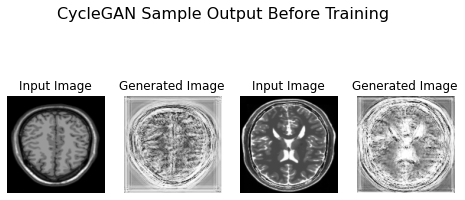

Epoch 1/15
86/86 [==============================] - ETA: 0s - G_loss: 21.8737 - F_loss: 18.5515 - D_X_loss: 0.2899 - D_Y_loss: 0.2821 - Total_Generator_Loss: 40.4251

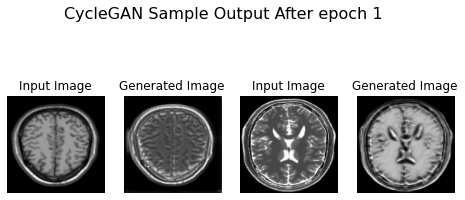

86/86 [==============================] - 339s 4s/step - G_loss: 21.9269 - F_loss: 18.5066 - D_X_loss: 0.2888 - D_Y_loss: 0.2796 - Total_Generator_Loss: 40.4335
Epoch 2/15
86/86 [==============================] - ETA: 0s - G_loss: 23.8553 - F_loss: 17.6673 - D_X_loss: 0.2194 - D_Y_loss: 0.1860 - Total_Generator_Loss: 41.5226

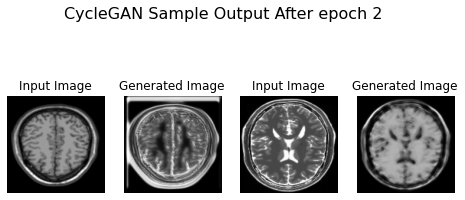

86/86 [==============================] - 314s 4s/step - G_loss: 23.8977 - F_loss: 17.6593 - D_X_loss: 0.2183 - D_Y_loss: 0.1848 - Total_Generator_Loss: 41.5569
Epoch 3/15
86/86 [==============================] - ETA: 0s - G_loss: 21.4644 - F_loss: 16.7618 - D_X_loss: 0.2565 - D_Y_loss: 0.2664 - Total_Generator_Loss: 38.2262

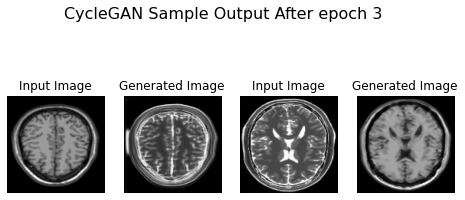

86/86 [==============================] - 316s 4s/step - G_loss: 21.4670 - F_loss: 16.7204 - D_X_loss: 0.2577 - D_Y_loss: 0.2648 - Total_Generator_Loss: 38.1874
Epoch 4/15
86/86 [==============================] - ETA: 0s - G_loss: 18.0094 - F_loss: 13.3797 - D_X_loss: 0.2953 - D_Y_loss: 0.2696 - Total_Generator_Loss: 31.3890

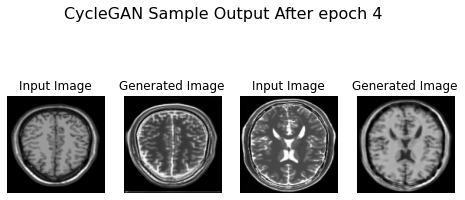

86/86 [==============================] - 316s 4s/step - G_loss: 17.9971 - F_loss: 13.3385 - D_X_loss: 0.2952 - D_Y_loss: 0.2672 - Total_Generator_Loss: 31.3356
Epoch 5/15
86/86 [==============================] - ETA: 0s - G_loss: 16.2476 - F_loss: 12.7478 - D_X_loss: 0.3163 - D_Y_loss: 0.2949 - Total_Generator_Loss: 28.9954

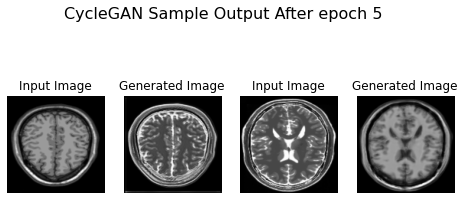

86/86 [==============================] - 314s 4s/step - G_loss: 16.2668 - F_loss: 12.7125 - D_X_loss: 0.3161 - D_Y_loss: 0.2930 - Total_Generator_Loss: 28.9794
Epoch 6/15
86/86 [==============================] - ETA: 0s - G_loss: 15.8721 - F_loss: 12.2811 - D_X_loss: 0.2931 - D_Y_loss: 0.2951 - Total_Generator_Loss: 28.1533

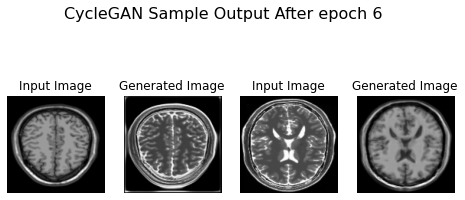

86/86 [==============================] - 316s 4s/step - G_loss: 15.8724 - F_loss: 12.2560 - D_X_loss: 0.2922 - D_Y_loss: 0.2931 - Total_Generator_Loss: 28.1284
Epoch 7/15
86/86 [==============================] - ETA: 0s - G_loss: 14.7487 - F_loss: 10.3976 - D_X_loss: 0.2999 - D_Y_loss: 0.3150 - Total_Generator_Loss: 25.1463

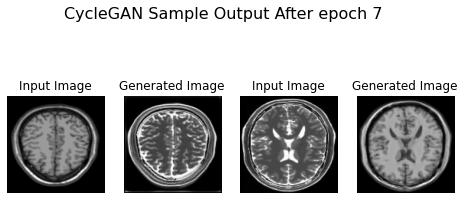

86/86 [==============================] - 316s 4s/step - G_loss: 14.7464 - F_loss: 10.3688 - D_X_loss: 0.2994 - D_Y_loss: 0.3124 - Total_Generator_Loss: 25.1152
Epoch 8/15
86/86 [==============================] - ETA: 0s - G_loss: 12.4308 - F_loss: 8.9890 - D_X_loss: 0.3181 - D_Y_loss: 0.3465 - Total_Generator_Loss: 21.4199

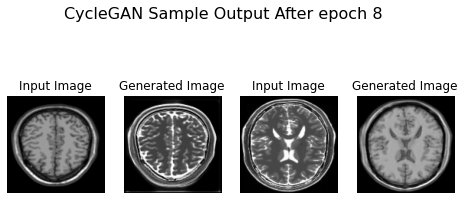

86/86 [==============================] - 314s 4s/step - G_loss: 12.4545 - F_loss: 8.9870 - D_X_loss: 0.3162 - D_Y_loss: 0.3445 - Total_Generator_Loss: 21.4415
Epoch 9/15
86/86 [==============================] - ETA: 0s - G_loss: 12.0993 - F_loss: 9.2899 - D_X_loss: 0.2905 - D_Y_loss: 0.3535 - Total_Generator_Loss: 21.3892

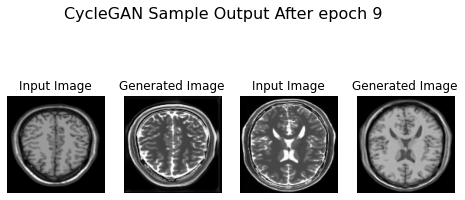

86/86 [==============================] - 317s 4s/step - G_loss: 12.0893 - F_loss: 9.2680 - D_X_loss: 0.2885 - D_Y_loss: 0.3531 - Total_Generator_Loss: 21.3573
Epoch 10/15
86/86 [==============================] - ETA: 0s - G_loss: 11.9954 - F_loss: 8.9130 - D_X_loss: 0.2867 - D_Y_loss: 0.3445 - Total_Generator_Loss: 20.9085

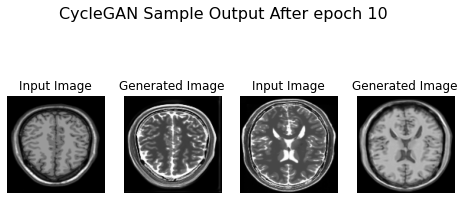

86/86 [==============================] - 315s 4s/step - G_loss: 12.0039 - F_loss: 8.8931 - D_X_loss: 0.2847 - D_Y_loss: 0.3422 - Total_Generator_Loss: 20.8971
Epoch 11/15
86/86 [==============================] - ETA: 0s - G_loss: 11.7776 - F_loss: 8.6749 - D_X_loss: 0.3184 - D_Y_loss: 0.3457 - Total_Generator_Loss: 20.4525

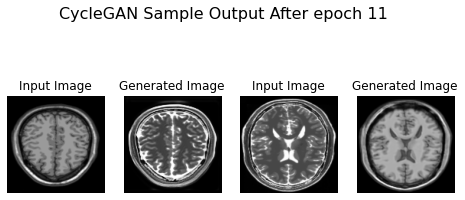

86/86 [==============================] - 317s 4s/step - G_loss: 11.7747 - F_loss: 8.6542 - D_X_loss: 0.3167 - D_Y_loss: 0.3434 - Total_Generator_Loss: 20.4289
Epoch 12/15
86/86 [==============================] - ETA: 0s - G_loss: 12.3293 - F_loss: 8.5090 - D_X_loss: 0.2860 - D_Y_loss: 0.2905 - Total_Generator_Loss: 20.8383

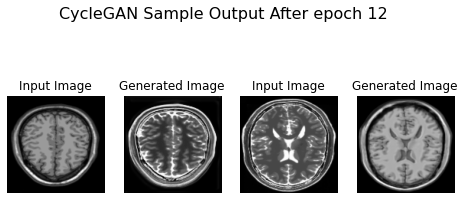

86/86 [==============================] - 315s 4s/step - G_loss: 12.3374 - F_loss: 8.4975 - D_X_loss: 0.2845 - D_Y_loss: 0.2883 - Total_Generator_Loss: 20.8349
Epoch 13/15
86/86 [==============================] - ETA: 0s - G_loss: 12.9401 - F_loss: 9.8654 - D_X_loss: 0.2835 - D_Y_loss: 0.2367 - Total_Generator_Loss: 22.8055

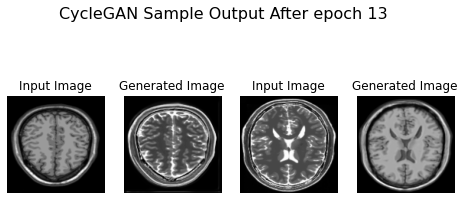

86/86 [==============================] - 317s 4s/step - G_loss: 12.9249 - F_loss: 9.8279 - D_X_loss: 0.2819 - D_Y_loss: 0.2352 - Total_Generator_Loss: 22.7528
Epoch 14/15
86/86 [==============================] - ETA: 0s - G_loss: 13.2197 - F_loss: 8.8819 - D_X_loss: 0.3355 - D_Y_loss: 0.2335 - Total_Generator_Loss: 22.1016

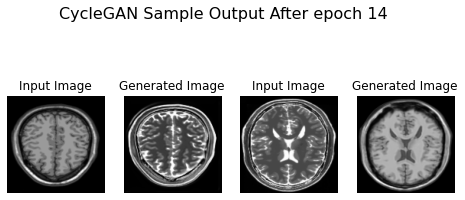

86/86 [==============================] - 317s 4s/step - G_loss: 13.1855 - F_loss: 8.8664 - D_X_loss: 0.3330 - D_Y_loss: 0.2338 - Total_Generator_Loss: 22.0519
Epoch 15/15
86/86 [==============================] - ETA: 0s - G_loss: 11.9201 - F_loss: 8.8038 - D_X_loss: 0.3693 - D_Y_loss: 0.3070 - Total_Generator_Loss: 20.7240

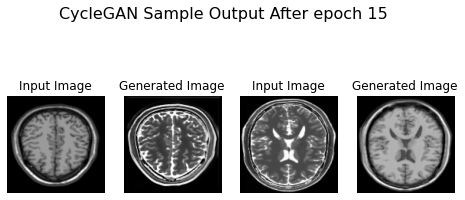

86/86 [==============================] - 315s 4s/step - G_loss: 11.9285 - F_loss: 8.7875 - D_X_loss: 0.3674 - D_Y_loss: 0.3051 - Total_Generator_Loss: 20.7160


ValueError: Model <__main__.CycleGan object at 0x7fca8cef4640> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined when calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)

In [37]:
epochs = 15

# Fitting the model
history = model.fit(tf.data.Dataset.zip((t1_dataset, t2_dataset)), epochs=epochs, batch_size = batch_size, 
                    callbacks=[plotter, model_checkpoint_callback])

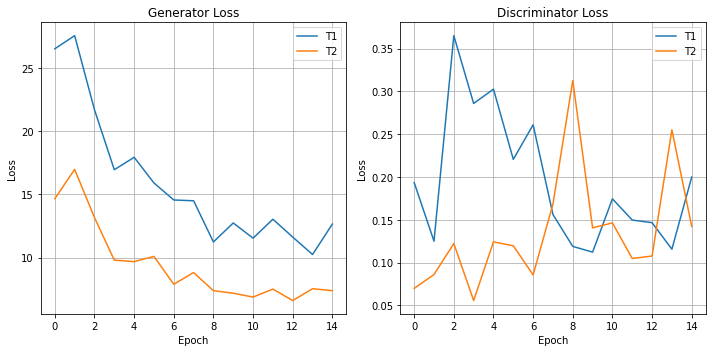

In [38]:
def plot_hist(hist):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(hist.history["G_loss"])
    plt.plot(hist.history["F_loss"])
    plt.legend(["T1", "T2"])
    plt.title("Generator Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history["D_X_loss"])
    plt.plot(hist.history["D_Y_loss"])
    plt.title("Discriminator Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["T1", "T2"])
    plt.tight_layout()
    plt.show()


plot_hist(history)

In [33]:
#!pip install git+https://github.com/tensorflow/docs

In [26]:
anim_file = "cyclegan_mri.gif"
pro_img_path = "Images/"
filenames = [pro_img_path + i for i in os.listdir(pro_img_path)]
filenames = sorted(filenames)

In [27]:
def reorder_images(filenames):
    sorted_files = []
    for filename in filenames:
        match = re.search(r"image_at_epoch_(\d+)", filename)
        if match:
            epoch_number = int(match.group(1))
            sorted_files.append((epoch_number, filename))
    sorted_files.sort()
    return [filename for _, filename in sorted_files]
filenames = reorder_images(filenames)

In [31]:
img_list = [imageio.imread(filename) for filename in filenames]
imageio.mimsave(anim_file, img_list, duration=1, loop=1)


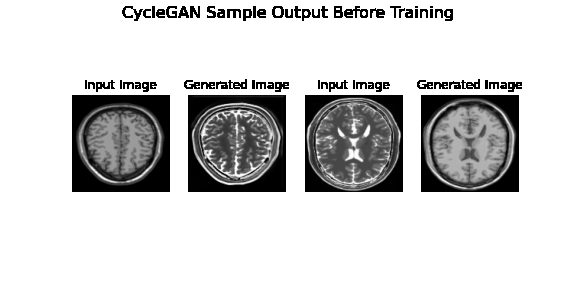

In [32]:
embed.embed_file(anim_file)

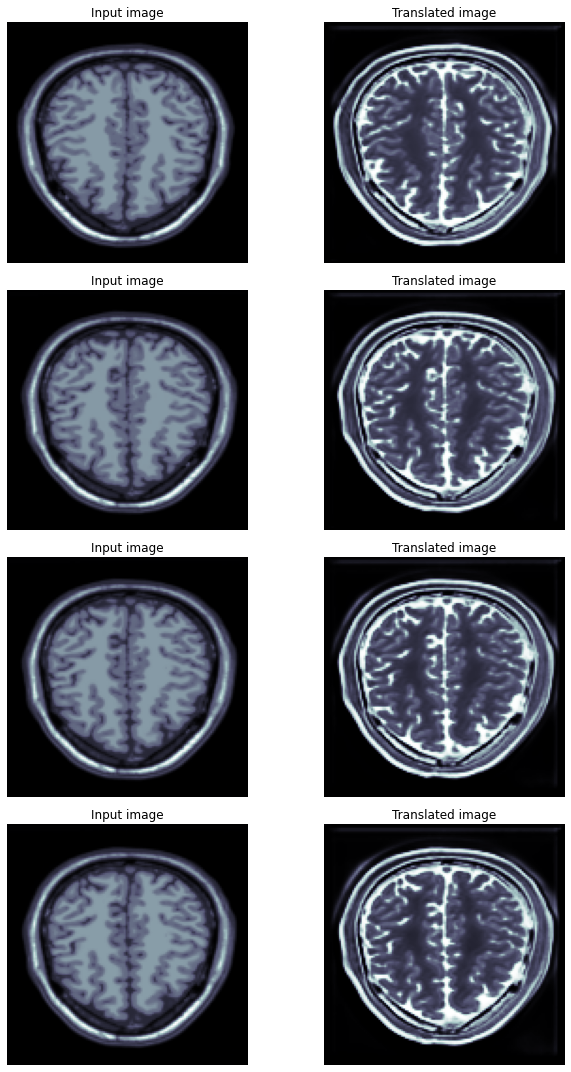

In [50]:
# evaluate the model for T1 to T2
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(t1_dataset.take(4)):
    prediction = model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img, cmap="bone")
    ax[i, 1].imshow(prediction, cmap="bone")
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = tf.keras.utils.array_to_img(prediction)
plt.tight_layout()
plt.show()

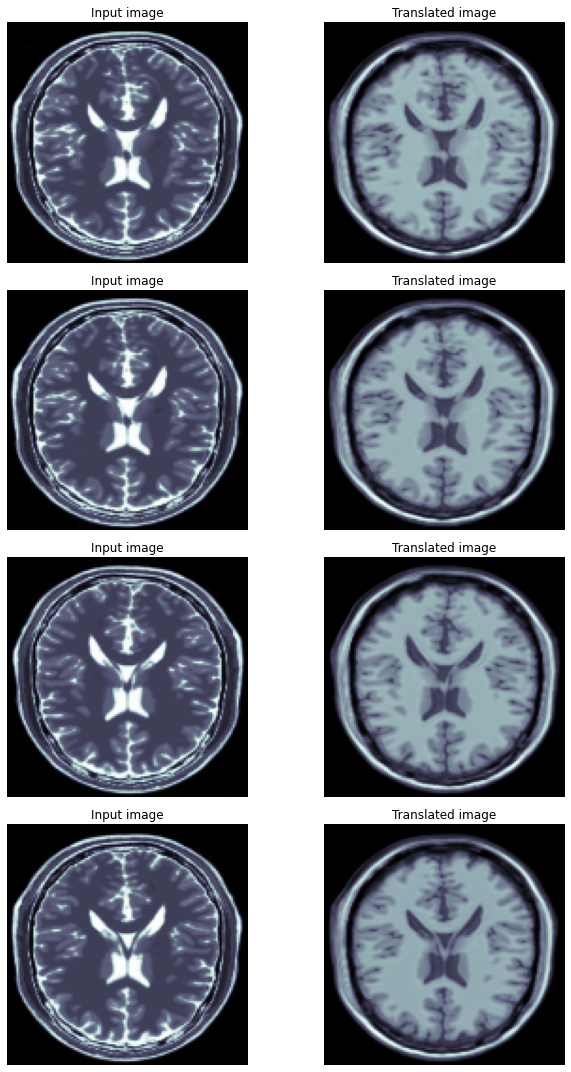

In [52]:
# evaluate the model for T2 to T1
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(t2_dataset.take(4)):
    prediction = model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img, cmap="bone")
    ax[i, 1].imshow(prediction, cmap="bone")
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = tf.keras.utils.array_to_img(prediction)
plt.tight_layout()
plt.show()